In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

References:
- [Vizuara's PINN from scratch](https://youtu.be/1AyAia_NZhQ?si=T9zNwyTr1aGciXrI)

In [18]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

print("imports done!")

imports done!


### Simulated Data

$$h \;\; = \;\; h_0 \; + \; u_0 t \; - \; \frac{1}{2} g t^2$$

In [51]:
# Generate Synthetic Data

# Physics parameters
g = 9.8        # acceleration due to gravity
h0 = 1.0       # initial height
v0 = 10.0      # initial velocity

# True (analytical) solution h(t) = h0 + v0*t - 0.5*g*t^2
def true_solution(t):
    return h0 + v0*t - 0.5*g*(t**2)

# Generate some time points
t_min, t_max = 0.0, 2.0
N_data = 20
t_data = np.linspace(t_min, t_max, N_data)

# Generate synthetic "experimental" heights with noise
np.random.seed(0)
noise_level = 0.7
h_data_exact = true_solution(t_data)
h_data_noisy = h_data_exact + noise_level*np.random.randn(N_data)

# Convert to PyTorch tensors
t_data_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
h_data_tensor = torch.tensor(h_data_noisy, dtype=torch.float32).view(-1, 1)

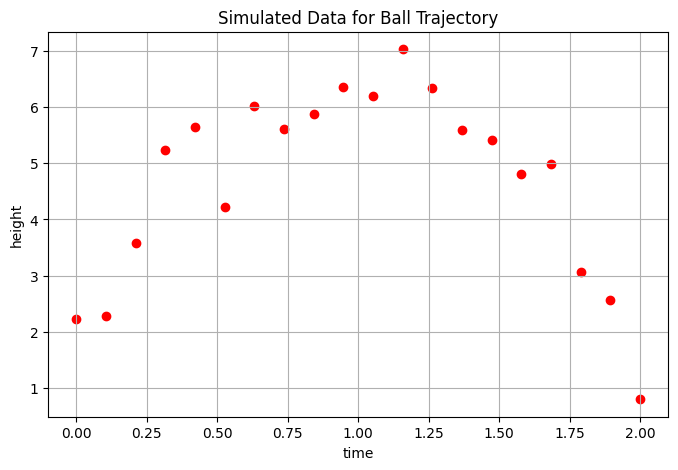

In [52]:
t_plot = np.linspace(t_min, t_max, 100).reshape(-1, 1).astype(np.float32)
plt.figure(figsize=(8, 5))
plt.scatter(t_data, h_data_noisy, color='red')
plt.xlabel('time')
plt.ylabel('height')
plt.title('Simulated Data for Ball Trajectory')
plt.grid(True)
plt.show()

### Physics behind the data

$$\frac{\text{dh}}{\text{dt}} = \text{u}_0 - \text{gt}$$

, where:
- h = height
- t = time
- $\text{u}_0$ = initial speed
- g = acceleration due to gravity = 9.8 m s$^{-2}$

### Neural Network

Mean Squared Error: $$\text{Loss} = \frac{1}{N} \sum_{i=1}^N (h_i - \hat{h}_i)^2$$

In [15]:
# Define a small feed-forward neural network for h(t)

class SimpleNN(nn.Module):
    def __init__(self, n_hidden=20):
        super(SimpleNN, self).__init__()
        # A simple MLP with 2 hidden layers
        self.net = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, t):
        """
        Forward pass: input shape (batch_size, 1) -> output shape (batch_size, 1)
        """
        return self.net(t)



### Physics-Informed Neural Network (PINN)

#### First loss term (Data-based loss)

$$\text{Loss} = \frac{1}{N} \sum_{i=1}^N (h_i - \hat{h}_i)^2$$


#### Second loss term (ODE loss)

The PINN will predict $\frac{\text{dh}}{\text{dt}}$, ie, $\hat{\frac{\text{dh}}{\text{dt}}}$.

So, the updated MSE will look like:

\begin{align*}
\text{Loss} &= \frac{1}{N} \; \sum_{i=1}^N \; \left(\frac{\text{dh}}{\text{dt}_i} - \hat{\frac{\text{dh}}{\text{dt}_i}}\right)^2 \\ \\
&= \frac{1}{N} \; \sum_{i=1}^N \; \left(\text{u}_0 - \text{gt}_i - \hat{\frac{\text{dh}}{\text{dt}_i}}\right)^2
\end{align*}


#### Third loss term (Initial Condition loss)

$$\text{Loss} \; = \; \left[h(0) \; - \; \hat{h}(0)\right]^2$$

, where:
- $h(0)$ = initial condition
- $\hat{h}(0)$ = predicted initial condition

#### The full loss term

\begin{align*}
\text{Loss} \; &= \; \text{Data-based loss} \, + \, \text{ODE loss} \, + \, \text{Initial Condition Loss} \\ \\
&= \;\; \frac{1}{N} \sum_{i=1}^N (h_i - \hat{h_i})^2 \;\; + \;\; \frac{1}{N} \; \sum_{i=1}^N \; \left(\text{u}_0 - \text{gt}_i - \hat{\frac{\text{dh}}{\text{dt}_i}}\right)^2 \;\; + \;\; \left[h(0) \; - \; \hat{h}(0)\right]^2
\end{align*}

In [6]:
# Automatic differentiation

def derivative(y, x):
    """
    Computes dy/dx using PyTorch's autograd.
    y and x must be tensors with requires_grad=True for x.
    """
    return torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

In [7]:
# All the 3 loss functions:
#    (1) Data loss (fit noisy data)
#    (2) ODE loss: dh/dt = v0 - g * t
#    (3) Initial condition loss: h(0) = h0

def physics_loss(model, t):
    """
    Compare d(h_pred)/dt with the known expression (v0 - g t).
    """
    # t must have requires_grad = True for autograd to work
    t.requires_grad_(True)

    h_pred = model(t)
    dh_dt_pred = derivative(h_pred, t)

    # For each t, physics says dh/dt = v0 - g * t
    dh_dt_true = v0 - g * t

    loss_ode = torch.mean((dh_dt_pred - dh_dt_true)**2)
    return loss_ode


def initial_condition_loss(model):
    """
    Enforce h(0) = h0.
    """
    # Evaluate at t=0
    t0 = torch.zeros(1, 1, dtype=torch.float32, requires_grad=False)
    h0_pred = model(t0)
    return (h0_pred - h0).pow(2).mean()


def data_loss(model, t_data, h_data):
    """
    MSE between predicted h(t_i) and noisy measurements h_data.
    """
    h_pred = model(t_data)
    return torch.mean((h_pred - h_data)**2)

In [29]:
def train(model, optimizer, lambda_data, lambda_ode, lambda_ic, num_epochs=4000, print_every=200):
    model.train()
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
    
        # Compute losses
        l_data = data_loss(model, t_data_tensor, h_data_tensor)
        l_ode  = physics_loss(model, t_data_tensor)
        l_ic   = initial_condition_loss(model)
    
        # Combined loss
        loss = lambda_data * l_data + lambda_ode * l_ode + lambda_ic * l_ic
    
        # Backprop
        loss.backward()
        optimizer.step()
    
        # Print progress
        if (epoch+1) % print_every == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, "
                  f"Total Loss = {loss.item():.6f}, "
                  f"Data Loss = {l_data.item():.6f}, "
                  f"ODE Loss = {l_ode.item():.6f}, "
                  f"IC Loss = {l_ic.item():.6f}")


print("training function created!")

training function created!


In [30]:
def evaluation_visualization(model, model_name):
    model.eval()
    t_plot = np.linspace(t_min, t_max, 100).reshape(-1, 1).astype(np.float32)
    t_plot_tensor = torch.tensor(t_plot, requires_grad=True)
    h_pred_plot = model(t_plot_tensor).detach().numpy()
    
    # True solution (for comparison)
    h_true_plot = true_solution(t_plot)
    
    # Plot results
    plt.figure(figsize=(8, 5))
    plt.scatter(t_data, h_data_noisy, color='red', label='Noisy Data')
    plt.plot(t_plot, h_true_plot, 'k--', label='Exact Solution')
    plt.plot(t_plot, h_pred_plot, 'b', label=f'{model_name} Prediction')
    plt.xlabel('t')
    plt.ylabel('h(t)')
    plt.legend()
    plt.title(f'{model_name} for Ball Trajectory')
    plt.grid(True)
    plt.show()


print("evaluation and visualization function created!")

evaluation and visualization function created!


In [31]:
# simple neural network
model1 = SimpleNN(n_hidden=20)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)

# Hyperparameters for weighting the loss terms for simple nn
lambda_data1 = 1
lambda_ode1  = 0
lambda_ic1   = 0

train(model1, optimizer1, lambda_data1, lambda_ode1, lambda_ic1, print_every=1000)

 27%|██▋       | 1077/4000 [00:02<00:06, 446.01it/s]

Epoch 1000/4000, Total Loss = 0.067263, Data Loss = 0.067263, ODE Loss = 30.275372, IC Loss = 1.526641


 51%|█████▏    | 2059/4000 [00:04<00:04, 416.52it/s]

Epoch 2000/4000, Total Loss = 0.000000, Data Loss = 0.000000, ODE Loss = 13.610123, IC Loss = 1.524821


 77%|███████▋  | 3077/4000 [00:07<00:02, 413.44it/s]

Epoch 3000/4000, Total Loss = 0.000000, Data Loss = 0.000000, ODE Loss = 13.610051, IC Loss = 1.524821


100%|██████████| 4000/4000 [00:09<00:00, 421.55it/s]

Epoch 4000/4000, Total Loss = 0.000000, Data Loss = 0.000000, ODE Loss = 13.590700, IC Loss = 1.524822


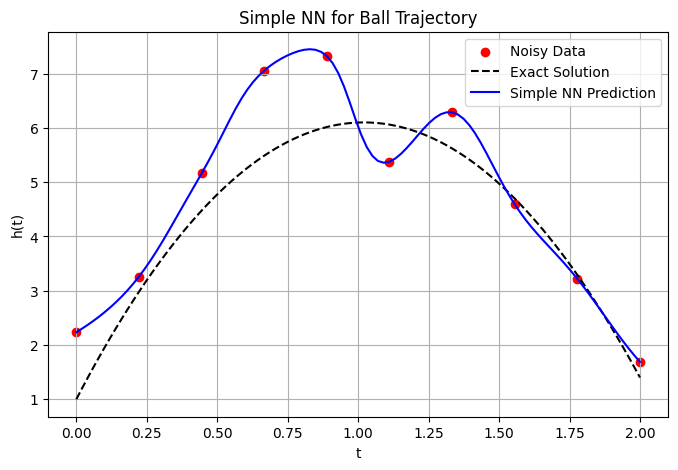

In [32]:
evaluation_visualization(model1, "Simple NN")

In [39]:
# physics-informed neural network
model2 = SimpleNN(n_hidden=20)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)

# Hyperparameters for weighting the loss terms for pinn
lambda_data2 = 2
lambda_ode2  = 10.0
lambda_ic2   = 10.0

train(model2, optimizer2, lambda_data2, lambda_ode2, lambda_ic2, print_every=1000)

 26%|██▌       | 1046/4000 [00:02<00:06, 449.76it/s]

Epoch 1000/4000, Total Loss = 1.092631, Data Loss = 0.536719, ODE Loss = 0.001271, IC Loss = 0.000648


 52%|█████▏    | 2083/4000 [00:04<00:04, 441.60it/s]

Epoch 2000/4000, Total Loss = 1.083909, Data Loss = 0.531998, ODE Loss = 0.001376, IC Loss = 0.000615


 77%|███████▋  | 3076/4000 [00:07<00:02, 444.79it/s]

Epoch 3000/4000, Total Loss = 1.076174, Data Loss = 0.527522, ODE Loss = 0.001526, IC Loss = 0.000587


100%|██████████| 4000/4000 [00:09<00:00, 432.47it/s]

Epoch 4000/4000, Total Loss = 1.070445, Data Loss = 0.524596, ODE Loss = 0.001541, IC Loss = 0.000584


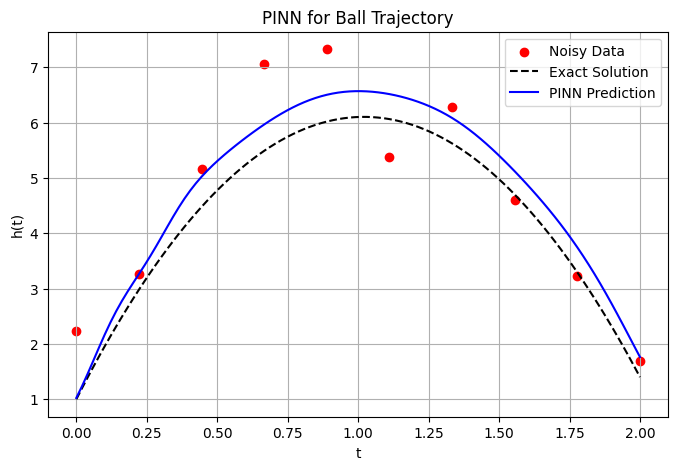

In [40]:
evaluation_visualization(model2, "PINN")